<a href="https://colab.research.google.com/github/rudradeep22/Graph_Neural_Networks/blob/main/GNN_knowledge_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check cuda version
!python -c "import torch; print(torch.version.cuda)"

12.1


In [3]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 64.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# Using cora dataset
# https://graphsandnetworks.com/the-cora-dataset/

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [5]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [7]:
# Info about our dataset

print(f'No. of graphs: {len(dataset)}')
print(f'No. of features: {dataset.num_features}')
print(f'No. of classes: {dataset.num_classes}')
data = dataset[0] # only one graph

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes}')
print(f'Is undirected?  {data.is_undirected()}')

No. of graphs: 1
No. of features: 1433
No. of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.051698670605613
Is undirected?  True


In [8]:
# Labels are converted to numbers

data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [9]:
# Adjacency network
data.edge_index.T

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [11]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [34]:
'''
training = self.training in dropout ensure that dropout occurs only during
training and not during predictions
'''
class GCN(torch.nn.Module):
  def __init__ (self, hidden_channels):
    super(GCN, self).__init__()
    torch.manual_seed(42)

    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.linear = Linear(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)

    x = self.conv2(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)

    output = F.softmax(self.linear(x), dim=1)
    return output

In [35]:
model = GCN( hidden_channels=16 )
model

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (linear): Linear(in_features=16, out_features=7, bias=True)
)

In [36]:
# Enable GPU
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)
model.to(device)
data.to(device)

cuda


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [37]:
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
num_epoch = 1000

In [38]:
def train():
  model.train()

  optimizer.zero_grad()
  output = model(data.x, data.edge_index)
  loss = criterion(output[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss
# use train mask while calculating loss, but use all data as input into model

In [39]:
def test():
  model.eval()

  output = model(data.x, data.edge_index)
  prediction = output.argmax(dim=1)
  correct = prediction[data.test_mask] == data.y[data.test_mask]
  acc = int(correct.sum()) / int(data.test_mask.sum())
  return acc

In [40]:
losses = []
accuracies = []
for epoch in range(0, num_epoch):
  loss = train()
  losses.append(loss)
  acc = test()
  accuracies.append(acc)
  if epoch % 100 == 0:
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Epoch: 0, Loss: 1.9461, Accuracy: 0.1030
Epoch: 100, Loss: 1.7376, Accuracy: 0.2580
Epoch: 200, Loss: 1.5091, Accuracy: 0.4860
Epoch: 300, Loss: 1.4761, Accuracy: 0.6290
Epoch: 400, Loss: 1.4391, Accuracy: 0.6610
Epoch: 500, Loss: 1.3845, Accuracy: 0.6760
Epoch: 600, Loss: 1.3566, Accuracy: 0.6850
Epoch: 700, Loss: 1.3698, Accuracy: 0.7000
Epoch: 800, Loss: 1.3569, Accuracy: 0.7060
Epoch: 900, Loss: 1.3662, Accuracy: 0.7030


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

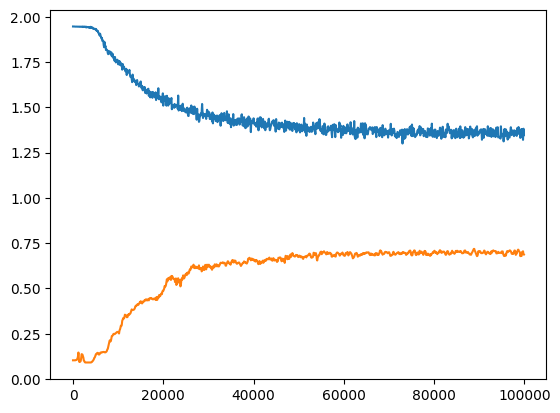

In [46]:
loss_cpu = [loss.cpu().detach().numpy() for loss in losses]
epochs = [i*100 for i in range(0, num_epoch)]
plt.plot(epochs, loss_cpu)
plt.plot(epochs, accuracies)